In [14]:
from setup import *
import sys
if DATA_PATH not in sys.path: sys.path.append(DATA_PATH)
from constants import *

%matplotlib inline
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', 200)

In [15]:
from gensim.models import TfidfModel, LsiModel
from gensim.corpora import Dictionary

So the new things are LsiModel and scatmat

In [16]:
dates = pd.read_csv(os.path.join(DATA_PATH, 'datetimes.csv.gz'), engine='python')
nums = pd.read_csv(os.path.join(DATA_PATH, 'numbers.csv.gz'), engine='python')
df = pd.read_csv(os.path.join(DATA_PATH, 'text.csv.gz'))
df.tokens

0         ['python', 'never', 'stop', 'learning', 'what'...
1                       ['Watching', 'Boa', 'vs', 'Python']
2         ['Monty', 'Python', 'The', 'silly', 'walk', 'v...
3         ['Senior', 'Software', 'Engineer', 'Full', 'St...
4         ['Architect', 'Django', 'Solr', 'Platform', 'E...
5           ['peaceful', 'rain', 'Python', 'inevitability']
                                ...                        
183064    ['Las', 'mejores', 'ides', 'para', 'Python', '...
183065    ['Gagal', 'tidur', 'gegara', 'habis', 'vertica...
183066         ['Go', 'boa', 'wkwk', 'Boa', 'vs', 'Python']
183067    ['RT', 'RealPython', 'List', 'of', 'Python', '...
183068                  ['Watching', 'Boa', 'vs', 'Python']
183069    ['Чертова', 'дюжина', 'вакансий', 'в', 'IT', '...
Name: tokens, dtype: object

Load cleaned tweet data  
Don't forget to fix up the tokens!  
Can you think of a better way to save a list of lists of strings?
What about the raw, unprocessed unicode tweet text itself?

In [17]:
nums = pd.read_csv(os.path.join(DATA_PATH, 'datetimes.csv.gz'))



### Load the vocabulary we built earlier
### *Or* recompile the vocabulary from the texts (tokens)

In [52]:
vocab = Dictionary(df.txt.str.split())
print(vocab)

Dictionary(87147 unique tokens: ['publishes', 'hubtartu', 'Fluvalaquatics', 'ttchen', 'MatrixFactorization']...)
{}


### Everything the TFIDF needs is in the Dictionary (vocabulary)

In [32]:
tfidf = TfidfModel(id2word=vocab, dictionary=vocab)
tfidf.num_docs

183070

In [20]:
bows = pd.Series(vocab.doc2bow(toks) for toks in df.txt.str.split())
bows

0         [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...
1                        [(8, 1), (9, 1), (10, 1), (11, 1)]
2         [(11, 1), (12, 1), (13, 1), (14, 1), (15, 1), ...
3         [(11, 1), (18, 1), (19, 1), (20, 1), (21, 1), ...
4         [(11, 1), (18, 1), (20, 1), (23, 1), (27, 1), ...
5                      [(11, 1), (37, 1), (38, 1), (39, 1)]
                                ...                        
183064    [(4, 1), (11, 1), (70, 1), (3257, 1), (3529, 1...
183065    [(8, 1), (9, 1), (11, 1), (138, 1), (1304, 1),...
183066    [(8, 1), (9, 1), (11, 1), (1669, 1), (3955, 1)...
183067    [(4, 1), (11, 1), (59, 1), (238, 1), (310, 2),...
183068                   [(8, 1), (9, 1), (10, 1), (11, 1)]
183069    [(11, 1), (26, 1), (653, 1), (1669, 1), (13176...
dtype: object

This would make a nice, compact sparse matrix representation of our entire corpus...  
Which would mean we could do more in RAM at once.  
Left as an exercise.  (check out `scipy.sparse.coo_matrix`)  

In [53]:
vocab.token2id['publishes']

1273

In [31]:
dict([(vocab[i], freq) for i, freq in tfidf[bows[0]]])

{'doing': 0.38193305364132873,
 'enjoy': 0.5289850748046834,
 'learning': 0.29103076255378624,
 'never': 0.4033166758997975,
 'python': 0.08240440024536141,
 'stop': 0.4246266138896532,
 'what': 0.3150727899248045,
 'you': 0.20141891173472923}

Notice how "you" didn't get as much weight as "enjoy"  
Let's look at some other tweets  

In [9]:
from gensim.models import LsiModel
lsi = LsiModel.load(os.path.join(DATA_PATH, 'lsi'))
len(lsi.id2word)

86901

This is starting to look a lot like a set of vectors that we could use as features  
But wait, if I used the IDs as the vector index (column) numbers, how many features or "columns" would I have?

In [ ]:
len(vocab)

100k dimensions isn't a good idea  
Even for a masively parallel deep learning project this would be big  
Like the cat/dog picture classification on 256x256 images  
What about PCA (Principal Component Analysis) like is used on images?  
In NLP PCA is called LSI (Latent Semantic Analysis)  
That sounds cool!  
I want me some latent semantics (hidden meaning)  

In [33]:
lsi = LsiModel(tfidf[bows], num_topics=100, id2word=vocab, extra_samples=100, power_iters=2)
lsi

In [36]:
lsi.save(os.path.join(DATA_PATH, 'lsi'))

In [69]:
lsi4 = LsiModel(bows, num_topics=4, id2word=vocab, extra_samples=100, power_iters=2)
lsi4.save(os.path.join(DATA_PATH, 'lsi4'))
lsi4

In [41]:
topics = lsi4[bows]
df_topics = pd.DataFrame([dict(d) for d in topics], index=df.index, columns=range(5))


In [ ]:
df_topics4['favorites'] = (nums.favorite_count > 0).astype(int)

In [60]:
df_topics4['favorites'] = np.ceil(nums.favorite_count ** .13).astype(int)
df_topics4


,0,1,2,3,4,favorites
0,0.279246,0.644025,-0.159041,-0.259208,-0.128964,0
1,0.664247,-0.578260,0.144901,0.044227,-0.093921,0
2,0.728053,-0.587551,0.142273,0.075186,-0.129895,1
3,0.874018,-1.025440,0.506672,-0.843611,-0.181155,0
4,1.082223,-0.939508,0.617143,-1.436531,-0.077277,0
5,0.657642,-0.572345,0.143017,0.041250,-0.089767,0
...,...,...,...,...,...,...
183064,0.869770,0.011683,-0.046547,-0.247101,-0.212515,0
183065,0.702997,-0.564605,0.146534,0.052112,-0.100772,0
183066,0.670191,-0.580436,0.146313,0.042536,-0.096954,0


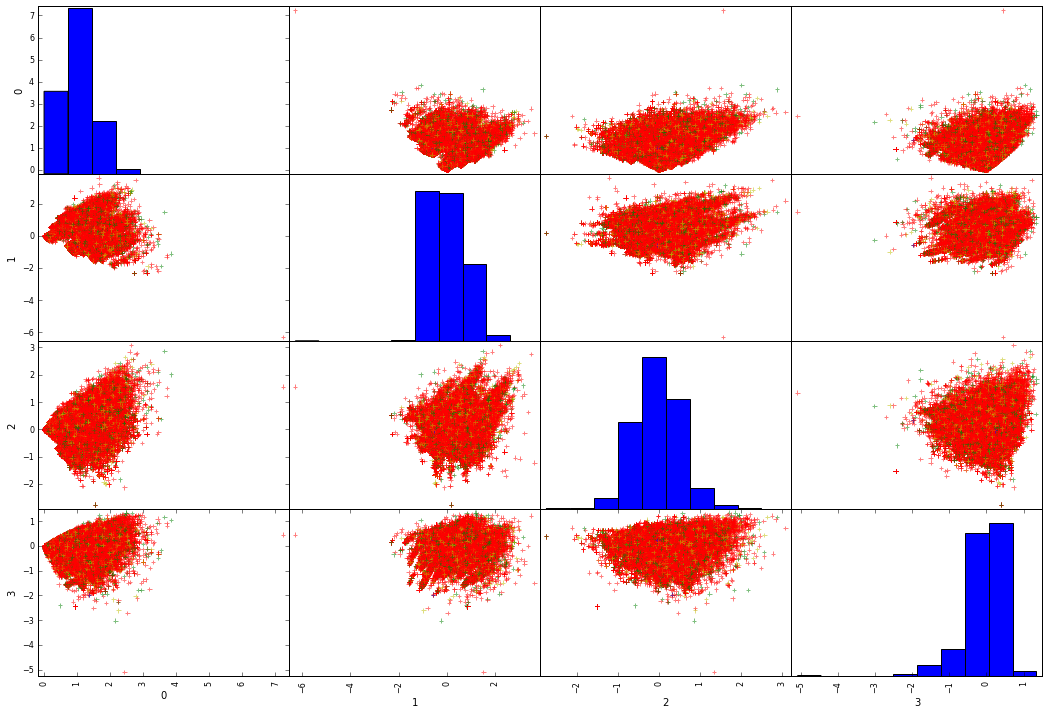

In [68]:
scatmat(df_topics, num_topics=4)

In [1]:
df = pd.DataFrame.from_csv(os.path.join(DATA_PATH, 'text.csv.gz'))
nums = pd.read_csv(os.path.join(DATA_PATH, 'numbers.csv.gz'), compression='gzip', engine='python')
vocab = Dictionary.from_documents(([str(s) for s in row]for row in df.txt.str.split()))
tfidf = TfidfModel(id2word=vocab, dictionary=vocab)
lsi = LsiModel.load(os.path.join(DATA_PATH, 'lsi'))
bows = pd.Series(vocab.doc2bow(toks) for toks in df.txt.str.split())
topics = lsi[bows]

NameError: name 'pd' is not defined

In [71]:
df_topics

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,favorites
0,0.280172,0.645190,-0.157156,-0.327782,0.015415,-0.014999,0.483952,-0.154137,0.240799,0.063167,0.119363,0.094626,-0.135290,0.122140,0.193363,0.002697,0.068299,0.025904,0.248716,0.692007,0.423768,-0.102020,-0.349437,0.054404,0.103062,-0.033871,-0.016174,0.010853,0.084489,-0.128339,-0.136022,-0.004152,0.094123,0.015972,0.110873,0.125792,-0.010306,-0.002119,-0.114695,-0.026637,-0.013192,0.052914,-0.041225,-0.050741,0.061092,-0.030267,0.034378,-0.012754,0.018169,0.057731,0.104373,0.007469,-0.049100,-0.004169,0.042586,-0.058043,-0.092664,0.076392,0.074233,-0.018681,0.089404,0.009699,0.040680,-0.049278,-0.019616,0.029592,0.018924,0.022357,0.051319,0.046523,0.030449,0.067461,-0.001596,0.007642,-0.013412,-0.031710,0.000384,0.023221,-0.006413,0.108972,0.104001,0.048431,0.049651,0.008886,-0.010492,-0.141836,0.097200,0.085994,0.021212,-0.094674,0.046784,0.046888,0.148451,-0.007399,0.185036,-0.088651,0.088479,0.049042,0.070358,0.071591,0
1,0.663715,-0.580478,0.148490,0.057189,-0.037231,-0.000197,0.173045,-0.127133,0.055935,-0.015247,0.250299,0.067773,-0.171196,0.010900,0.061693,-0.080983,-0.082421,-0.006501,-0.091766,0.032953,0.072217,-0.033408,-0.046145,0.024451,-0.081986,-0.012791,0.026987,-0.022037,-0.036708,0.000637,0.033873,0.054592,-0.013473,-0.014232,-0.031760,0.047070,0.018214,0.012422,-0.009772,-0.000617,0.007393,0.040041,0.044413,-0.079550,0.029095,-0.022515,0.034118,-0.033704,0.028967,0.022471,0.021409,0.004848,-0.049721,0.026330,-0.019879,-0.077067,-0.019985,0.027985,0.009797,0.052440,0.001960,0.048176,-0.084344,-0.019261,-0.049036,-0.052190,0.014431,-0.032369,-0.011042,-0.014681,-0.069244,0.005356,-0.077368,-0.027810,-0.004997,-0.050013,-0.084956,-0.020075,0.050919,0.059778,-0.013075,0.030441,-0.037697,-0.072826,0.141673,0.005741,0.029627,-0.069367,0.012395,-0.030158,0.044979,-0.000945,0.076312,0.032291,0.039446,-0.035483,-0.016841,0.081544,0.029812,-0.007467,0
2,0.727361,-0.587704,0.145206,0.082223,-0.057350,-0.011299,0.201314,-0.158187,0.060609,-0.023160,0.338061,0.064668,-0.240718,0.005614,0.114138,-0.036048,-0.087398,0.068509,-0.165800,-0.051961,0.065984,-0.053798,-0.043702,0.243280,-0.088352,-0.027219,-0.030730,-0.013177,0.175770,-0.378035,-0.005225,-0.230089,0.104294,0.350606,-0.182940,-0.448534,-0.056096,0.004929,-0.154000,0.014849,0.097148,0.042973,0.008829,-0.396335,-0.167250,0.156450,0.107210,-0.517160,-0.631082,-0.392434,0.015933,-0.078136,-0.112470,-0.055096,-0.102148,0.079702,-0.023785,0.069265,0.198604,-0.004287,-0.212030,0.039328,0.258817,-0.003450,0.002982,-0.180837,-0.057673,0.110186,-0.120306,0.085802,-0.039256,-0.014410,-0.151422,-0.006477,0.009820,-0.011455,-0.124494,0.048210,-0.022603,-0.039890,0.011741,-0.015465,-0.014987,-0.050109,0.002109,-0.000518,-0.077904,-0.038942,0.002526,0.076421,-0.047575,-0.046619,-0.026164,0.008935,-0.062166,0.028394,0.010168,0.106901,-0.012600,0.119668,1
3,0.875706,-1.042393,0.488922,-1.032760,-0.026749,-0.088396,0.359527,-0.506103,0.808462,-0.033757,-1.072789,-0.704033,0.222333,-0.100345,-0.106241,0.182381,0.086618,0.027355,-0.282973,0.051965,0.003404,0.093949,-0.116667,-0.187203,0.133163,0.054593,0.204164,-0.564098,-0.031973,-0.128866,0.032662,-0.094287,0.083921,-0.174592,-0.004803,-0.083423,0.015334,-0.006701,-0.073123,-0.105053,-0.037366,-0.082046,0.211543,-0.063374,0.235030,-0.176463,0.002135,0.024126,-0.192945,-0.104253,-0.159646,0.417474,0.080754,-0.158687,0.045846,0.128120,0.196454,0.031857,-0.020152,-0.278651,-0.204720,0.048018,-0.088910,0.291889,-0.622359,0.045088,0.492575,0.147261,0.620369,0.053716,0.232457,-0.304015,-0.121995,0.187564,0.022024,0.296733,0.182747,-0.053161,0.038762,0.102695,0.109263,0.069359,0.103465,-0.002159,0.155772,-0.198050,-0.184370,-0.082029,-0.0

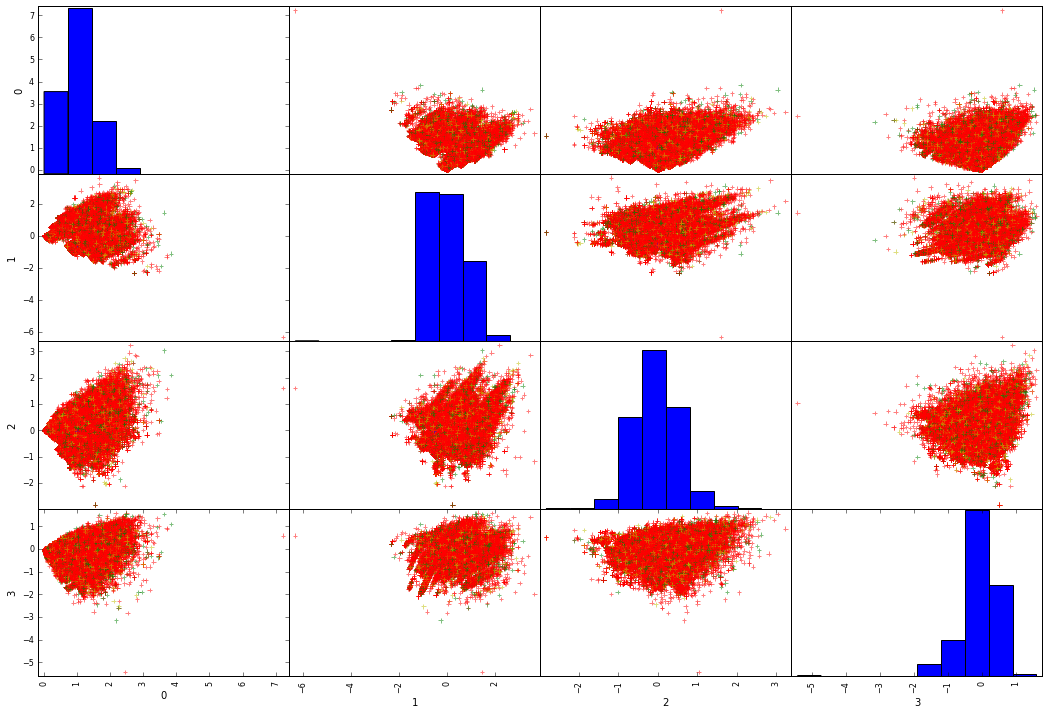

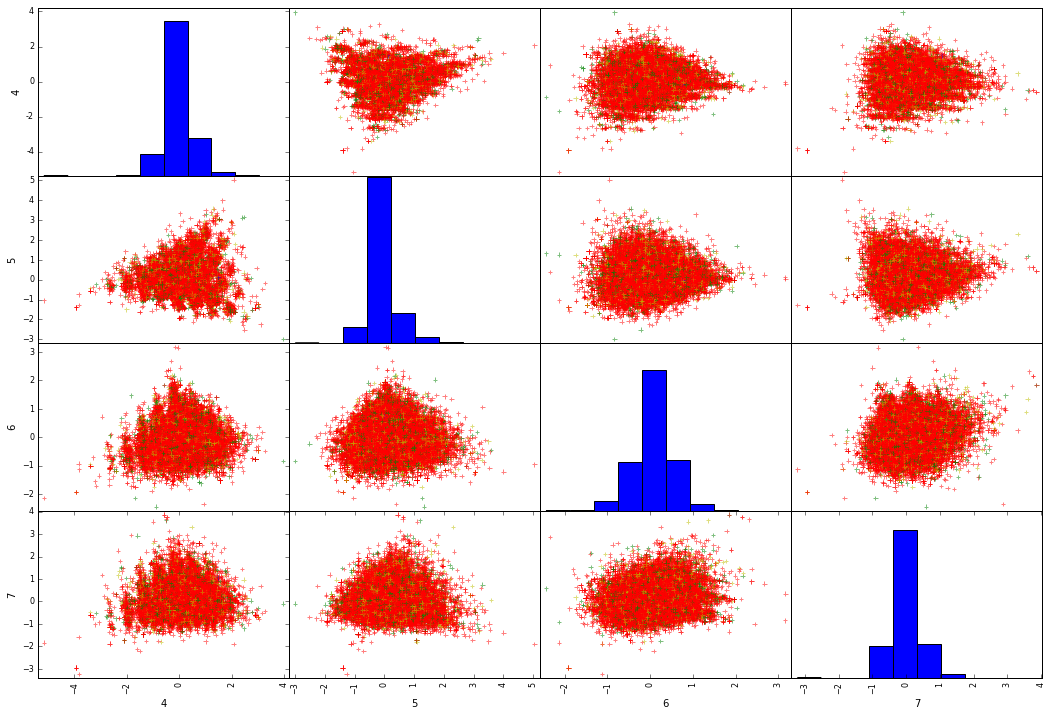

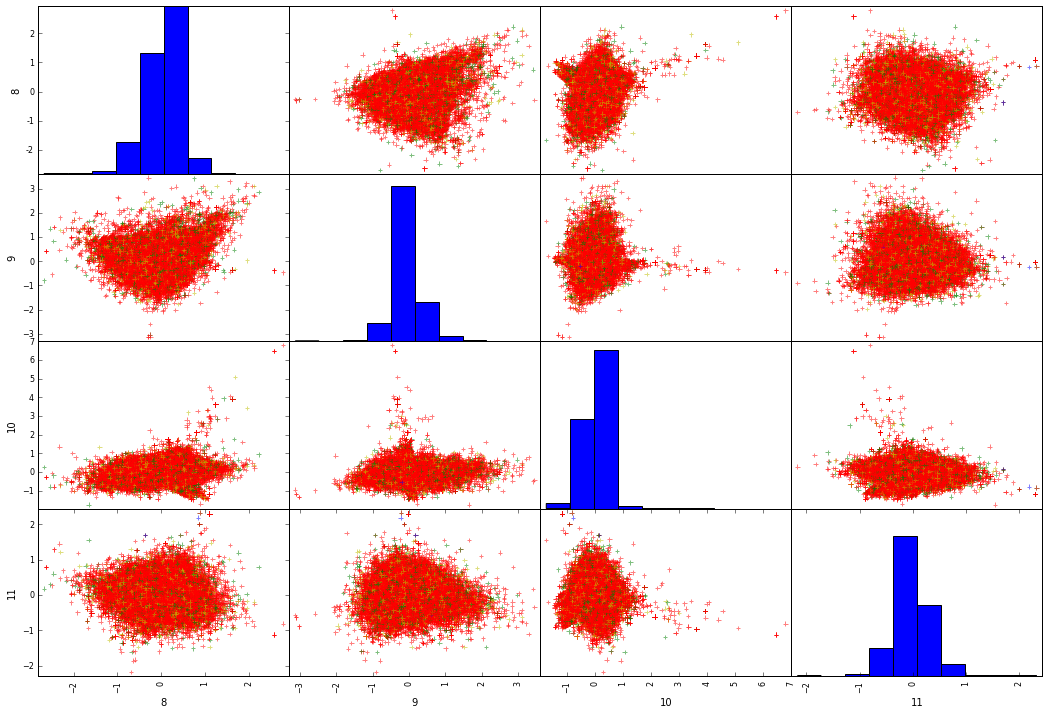

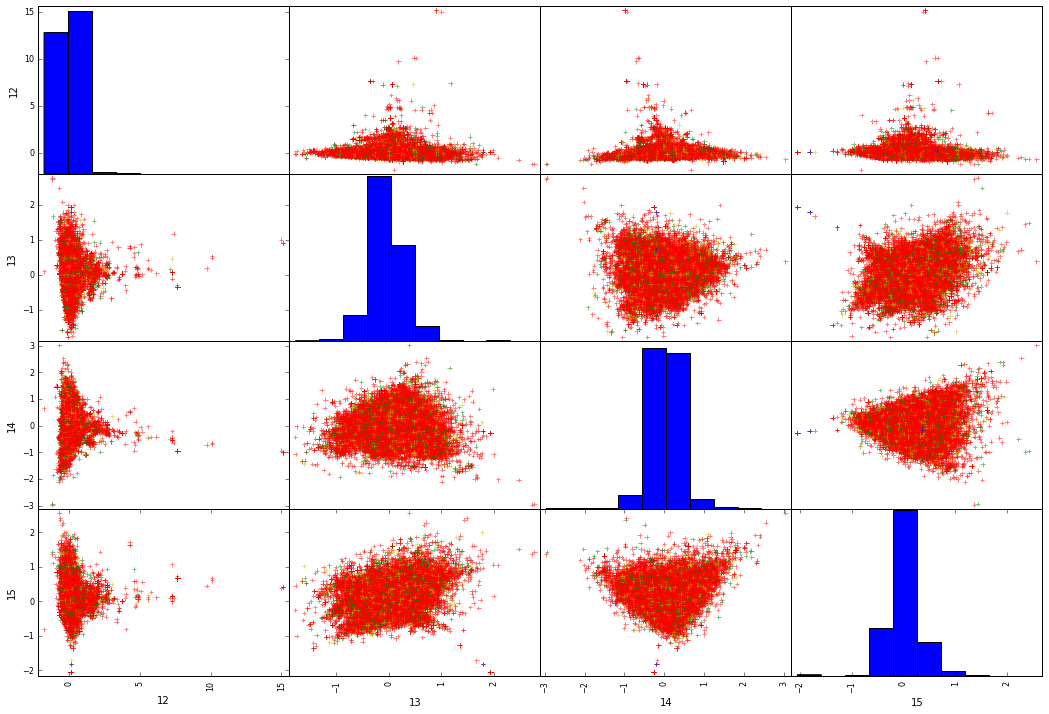

In [73]:
scatmat(df_topics)

## That's Fast!  
What happened to the **GIL**?  
The gilectomy talk isn't until tomorrow!  
Can Python do that?  
With `numpy` and `gensim` it can.  

What's that sound I hear?  
That's the sound mof your fans blowing *hot air* out of those tweets!  
(check out your system monitor or `htop`)  

In [28]:
tweetids = pd.Series(range(6), name='tweet')
topicids = pd.Series(range(lsi.num_topics), name='topic')
pd.DataFrame([pd.Series([x[1] for x in lsi[bows[i]]], index=topicids,
                        name='tweet') for i in tweetids],
             index=tweetids)


topic,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
tweet,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.28,0.65,-0.16,-0.33,0.02,-1.45e-02,0.48,-0.15,0.24,0.06,-0.12,-0.10,-0.14,1.24e-01,0.19,2.88e-03,0.07,-2.61e-02,0.25,0.69,4.21e-01,0.10,0.35,-0.06,0.10,-3.42e-02,-0.02,0.01,-0.08,-1.27e-01,-0.14,-1.18e-03,0.09,0.01,1.14e-01,0.12,0.01,3.88e-03,1.14e-01,-2.34e-02,8.72e-03,-0.06,-0.03,0.06,0.06,-0.03,0.04,7.79e-03,-0.02,-0.06,-9.21e-02,-0.04,-0.05,-2.77e-03,-0.05,4.81e-02,1.00e-01,-6.77e-02,-5.99e-02,-4.41e-02,9.86e-02,-7.40e-03,2.94e-02,6.66e-02,-5.87e-03,5.12e-02,3.48e-03,4.41e-02,-3.36e-02,-2.98e-02,-4.79e-02,-4.54e-02,7.93e-03,-3.02e-02,2.57e-02,-5.87e-02,0.03,-5.06e-03,-2.56e-02,-2.05e-02,-9.39e-02,3.91e-02,1.29e-01,-0.02,-6.72e-02,-0.13,0.05,-0.09,-4.17e-02,-5.32e-02,-4.56e-02,8.33e-03,2.59e-02,1.35e-01,1.52e-01,1.73e-01,-8.84e-02,6.54e-02,5.41e-02,2.94e-02
1,0.66,-0.58,0.15,0.06,-0.04,1.83e-04,0.17,-0.13,0.06,-0.02,-0.25,-0.07,-0.17,1.07e-02,0.06,-8.09e-02,-0.08,5.90e-03,-0.09,0.03,7.28e-02,0.03,0.05,-0.02,-0.08,-1.30e-02,0.03,-0.02,0.04,-5.06e-04,0.04,5.39e-02,-0.01,-0.01,-3.26e-02,0.05,-0.02,-1.54e-02,8.40e-03,1.47e-03,-1.06e-02,-0.04,0.05,0.08,0.03,-0.02,0.05,-2.03e-02,-0.03,-0.03,-1.89e-02,-0.01,-0.05,2.78e-02,0.02,7.46e-02,3.24e-02,-3.00e-02,-8.60e-03,5.39e-02,3.34e-03,-2.85e-02,-8.26e-02,1.60e-02,6.41e-02,-5.40e-02,2.66e-02,-7.94e-03,-2.88e-02,6.12e-04,-5.04e-02,4.97e-02,-6.44e-02,1.57e-02,-2.44e-02,-3.96e-02,0.10,-3.95e-02,-1.41e-01,6.43e-02,4.19e-02,1.92e-02,-7.03e-02,0.02,-3.87e-03,0.09,-0.02,0.05,1.81e-02,-2.28e-02,-1.53e-03,1.40e-02,1.16e-02,-8.98e-03,9.51e-02,2.44e-03,5.53e-02,3.33e-02,-1.42e-02,4.34e-02
2,0.73,-0.59,0.15,0.08,-0.06,-1.08e-02,0.20,-0.16,0.06,-0.02,-0.34,-0.07,-0.24,5.88e-03,0.11,-3.67e-02,-0.09,-6.82e-02,-0.17,-0.05,6.64e-02,0.05,0.04,-0.24,-0.09,-2.62e-02,-0.03,-0.01,-0.18,-3.84e-01,-0.02,-2.27e-01,0.10,0.35,-1.86e-01,-0.45,0.05,-1.09e-02,1.48e-01,3.17e-02,-9.25e-02,-0.02,0.03,0.38,-0.14,0.13,0.30,-4.44e-01,0.62,0.42,-8.57e-02,0.09,-0.12,-4.98e-02,0.10,-8.21e-02,2.42e-02,-1.02e-01,-1.96e-01,-2.29e-02,-1.88e-01,-1.11e-01,2.43e-01,7.44e-03,-3.80e-02,-1.81e-01,-2.32e-02,2.96e-02,1.55e-01,-8.53e-02,-4.48e-02,2.22e-02,-1.66e-01,9.72e-03,-1.06e-02,1.15e-02,0.13,2.63e-02,3.79e-02,2.46e-02,-6.93e-03,-5.94e-03,-5.48e-02,0.05,6.27e-02,0.02,-0.04,0.03,5.61e-02,1.42e-02,-2.90e-03,2.73e-02,-4.46e-02,-3.45e-02,3.19e-02,-5.64e-02,4.14e-02,7.66e-02,1.04e-02,4.29e-02
3,0.88,-1.04,0.49,-1.03,-0.03,-8.89e-02,0.36,-0.51,0.81,-0.04,1.07,0.71,0.22,-1.01e-01,-0.11,1.84e-01,0.09,-2.75e-02,-0.28,0.05,3.24e-03,-0.09,0.12,0.19,0.13,5.21e-02,0.20,-0.56,0.04,-1.32e-01,0.03,-9.20e-02,0.08,-0.17,-9.26e-03,-0.08,-0.02,-4.99e-03,7.07e-02,-1.06e-01,3.11e-02,0.10,0.21,0.06,0.25,-0.17,0.01,3.35e-02,0.20,0.12,2.74e-01,-0.35,0.06,-1.69e-01,-0.05,-8.05e-02,-2.04e-01,-1.39e-02,7.50e-03,-2.74e-01,-1.88e-01,-8.69e-02,-4.61e-02,-2.51e-01,6.13e-01,-2.88e-02,4.39e-01,4.34e-01,-4.63e-01,-3.64e-02,4.16e-01,8.83e-03,-8.95e-02,-1.70e-01,3.37e-03,2.22e-01,-0.26,-3.93e-02,-2.02e-01,4.66e-02,-7.28e-02,6.96e-03,1.46e-02,0.14,-1.74e-01,0.02,-0.17,0.04,4.77e-02,8.11e-03,2.91e-02,-8.06e-02,5.02e-02,-9.60e-02,-1.62e-01,-1.09e-01,-9.73e-02,-5.02e-03,2.63e-04,-3.74e-02
4,1.09,-0.96,0.55,-1.65,0.09,-9.28e-02,-0.03,-0.08,0.32,-0.02,0.78,0.53,0.24,-1.81e-01,-0.11,2.60e-01,0.18,-1.65e-01,-0.30,0.07,3.87e-02,-0.03,-0.01,0.06,-0.07,2.82e-02,0.02,0.18,-0.02,4.75e-02,-0.14,1.36e-01,0.70,-0.59,-1.50e-01,-0.46,-0.13,1.14e-01,-4.24e-02,-4.16e-02,3.93e-02,-0.05,-0.27,0.31,-0.14,0.03,0.06,1.45e-02,-0.11,-0.02,-3.50e-02,-0.41,-0.08,-6.46e-02,-0.10,7.97e-03,-5.98e-03,-7.08e-03,8.21e-02,2.32e-02,-2.31e-01,-1.40e-01,1.16e-02,-1.42e-01,1.74e-01,3.91e-02,2.54e-01,2.50e-01

In [30]:
lsi.save(os.path.join(DATA_PATH, 'lsi'))
lsi5.save(os.path.join(DATA_PATH, 'lsi5'))

In [5]:
lsi5 = LsiModel.load(os.path.join(DATA_PATH, 'lsi5'))

In [9]:
# for topic in lsi.show_topics():
#     print(topic)
lsi5.show_topic(0, 8)

[('Python', 0.65726304271525138),
 ('RT', 0.37730218261284065),
 ('to', 0.24256210419921637),
 ('a', 0.2425115388559333),
 ('in', 0.21979729720296687),
 ('python', 0.19540522901071722),
 ('the', 0.17746464991064059),
 ('and', 0.16362893535605519)]

In [10]:
lsi5.show_topic(0, 8)

[('Python', 0.65726304271525138),
 ('RT', 0.37730218261284065),
 ('to', 0.24256210419921637),
 ('a', 0.2425115388559333),
 ('in', 0.21979729720296687),
 ('python', 0.19540522901071722),
 ('the', 0.17746464991064059),
 ('and', 0.16362893535605519)]

## Hold onto your hat
This will take a lot of RAM!  
(and CPU)  

In [31]:
tweetids = pd.Series(range(len(bows)), name='tweet')
topicids = pd.Series(range(lsi.num_topics), name='topic')
# `dict()` keeps track of the columns for each topic, in case the lsi model shuffles or skips topics for odd tweets
df = pd.DataFrame([pd.Series(dict(lsi[bows[i]]), name='tweet') for i in tweetids],
                  columns=topicids,
                  index=tweetids)

In [32]:
df

topic,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
tweet,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.28,0.65,-0.16,-0.33,0.02,-1.45e-02,0.48,-0.15,0.24,0.06,-0.12,-0.10,-0.14,1.24e-01,0.19,2.88e-03,0.07,-2.61e-02,0.25,0.69,0.42,0.10,0.35,-5.55e-02,0.10,-0.03,-0.02,0.01,-0.08,-1.27e-01,-0.14,-1.18e-03,0.09,0.01,0.11,0.12,0.01,3.88e-03,1.14e-01,-2.34e-02,8.72e-03,-0.06,-3.45e-02,0.06,0.06,-0.03,0.04,7.79e-03,-0.02,-0.06,-9.21e-02,-0.04,-0.05,-2.77e-03,-4.78e-02,0.05,0.10,-0.07,-5.99e-02,-4.41e-02,9.86e-02,-7.40e-03,0.03,6.66e-02,-5.87e-03,5.12e-02,3.48e-03,4.41e-02,-0.03,-2.98e-02,-0.05,-0.05,7.93e-03,-3.02e-02,2.57e-02,-0.06,0.03,-5.06e-03,-2.56e-02,-0.02,-9.39e-02,3.91e-02,0.13,-0.02,-6.72e-02,-0.13,0.05,-0.09,-0.04,-5.32e-02,-4.56e-02,8.33e-03,2.59e-02,1.35e-01,0.15,1.73e-01,-0.09,0.07,0.05,0.03
1,0.66,-0.58,0.15,0.06,-0.04,1.83e-04,0.17,-0.13,0.06,-0.02,-0.25,-0.07,-0.17,1.07e-02,0.06,-8.09e-02,-0.08,5.90e-03,-0.09,0.03,0.07,0.03,0.05,-2.42e-02,-0.08,-0.01,0.03,-0.02,0.04,-5.06e-04,0.04,5.39e-02,-0.01,-0.01,-0.03,0.05,-0.02,-1.54e-02,8.40e-03,1.47e-03,-1.06e-02,-0.04,5.33e-02,0.08,0.03,-0.02,0.05,-2.03e-02,-0.03,-0.03,-1.89e-02,-0.01,-0.05,2.78e-02,2.32e-02,0.07,0.03,-0.03,-8.60e-03,5.39e-02,3.34e-03,-2.85e-02,-0.08,1.60e-02,6.41e-02,-5.40e-02,2.66e-02,-7.94e-03,-0.03,6.12e-04,-0.05,0.05,-6.44e-02,1.57e-02,-2.44e-02,-0.04,0.10,-3.95e-02,-1.41e-01,0.06,4.19e-02,1.92e-02,-0.07,0.02,-3.87e-03,0.09,-0.02,0.05,0.02,-2.28e-02,-1.53e-03,1.40e-02,1.16e-02,-8.98e-03,0.10,2.44e-03,0.06,0.03,-0.01,0.04
2,0.73,-0.59,0.15,0.08,-0.06,-1.08e-02,0.20,-0.16,0.06,-0.02,-0.34,-0.07,-0.24,5.88e-03,0.11,-3.67e-02,-0.09,-6.82e-02,-0.17,-0.05,0.07,0.05,0.04,-2.43e-01,-0.09,-0.03,-0.03,-0.01,-0.18,-3.84e-01,-0.02,-2.27e-01,0.10,0.35,-0.19,-0.45,0.05,-1.09e-02,1.48e-01,3.17e-02,-9.25e-02,-0.02,3.06e-02,0.38,-0.14,0.13,0.30,-4.44e-01,0.62,0.42,-8.57e-02,0.09,-0.12,-4.98e-02,1.01e-01,-0.08,0.02,-0.10,-1.96e-01,-2.29e-02,-1.88e-01,-1.11e-01,0.24,7.44e-03,-3.80e-02,-1.81e-01,-2.32e-02,2.96e-02,0.15,-8.53e-02,-0.04,0.02,-1.66e-01,9.72e-03,-1.06e-02,0.01,0.13,2.63e-02,3.79e-02,0.02,-6.93e-03,-5.94e-03,-0.05,0.05,6.27e-02,0.02,-0.04,0.03,0.06,1.42e-02,-2.90e-03,2.73e-02,-4.46e-02,-3.45e-02,0.03,-5.64e-02,0.04,0.08,0.01,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183067,1.43,0.12,-0.84,-0.15,-0.25,-1.56e-01,0.27,-0.58,0.48,-0.18,-1.24,0.63,1.15,4.92e-01,-0.63,1.37e-01,0.13,1.92e-01,-0.05,0.05,-0.02,0.22,0.21,-3.17e-02,-0.08,-0.18,0.09,0.04,0.06,-6.53e-02,0.08,1.47e-01,0.01,0.06,-0.04,0.11,-0.04,-2.39e-02,6.61e-02,-9.21e-02,-9.32e-02,0.06,-3.46e-03,0.16,0.05,0.02,0.08,2.65e-02,-0.09,-0.07,-2.46e-03,0.02,0.04,1.63e-02,-7.69e-02,0.04,0.04,-0.06,1.95e-02,-6.10e-02,-2.33e-02,-1.75e-02,0.01,-1.38e-02,5.04e-02,-3.35e-02,4.59e-02,-4.45e-02,0.06,8.02e-02,-0.04,0.04,4.99e-02,-3.60e-03,4.03e-02,0.03,0.04,2.95e-02,-6.37e-02,-0.07,-6.74e-02,-3.98e-02,0.05,-0.06,-5.73e-02,0.03,0.05,0.02,0.02,9.91e-03,1.63e-02,7.45e-02,2.04e-03,6.69e-02,0.03,3.06e-02,-0.05,-0.03,0.10,-0.08
183068,0.66,-0.58,0.15,0.06,-0.04,1.83e-04,0.17,-0.13,0.06,-0.02,-0.25,-0.07,-0.17,1.07e-02,0.06,-8.09e-02,-0.08,5.90e-03,-0.09,0.03,0.07,0.03,0.05,-2.42e-02,-0.08,-0.01,0.03,-0.02,0.04,-5.06e-04,0.04,5.39e-02,-0.01,-0.01,-0.03,0.05,-0.02,-1.54e-02,8.40e-03,1.47e-03,-1.06e-02,-0.04,5.33e-02,0.08,0.03,-0.02,0.05,-2.03e-02,-0.03,-0.03,-1.89e-02,-0.

What's with the 1.43?  
Aren't they normalize?  
... Nope  

In [12]:
scatmat(df[df.columns[:5]][::100])

NameError: name 'df' is not defined

In [ ]:
num

In [ ]:
with gzip.open(os.path.join(DATA_PATH, 'tweet_topic_vectors.csv.gz'), 'wb') as f:
    df.to_csv(f, encoding='utf8', quoting=pd.io.common.csv.QUOTE_NONNUMERIC)

We built LSI topic vectors for 200k tweets in a few minutes!  
Lets look at the TFIDF vectors for the top 6 tweets

In [10]:
tfidf6 = pd.DataFrame((dict([(vocab[i], freq) for i, freq in tfidf[bows[j]]]) for j in range(6)))
tfidf6 = tfidf6.fillna('')
tfidf6

NameError: global name 'tfidf' is not defined

Notice the small weights on the word "Python"?
Why do you think that is?
(Think back to the definition of TF and DF and TFIDF

Now lets see how far apart they are based only on word frequency (TFIDF)
We'll *"project"* the first tweet onto the second with a dot product  
to see how much of a "shadow" they make on each other  

In [ ]:
tfidf6 = pd.DataFrame((dict([(vocab[i], freq) for i, freq in tfidf[bows[j]]]) for j in range(6))).fillna(0).T

In [ ]:
np.dot(tfidf6[0], tfidf6[1])

In [ ]:
np.dot(tfidf6[1], tfidf6[2])

That looks about right.  
The first 2 share no words.  
The second 2 share only "Python".  
But lets do the cosine similarity correctly by normalizing for length.  

In [ ]:
np.dot(tfidf6[1], tfidf6[2]) / np.linalg.norm(tfidf6[1]) / np.linalg.norm(tfidf6[2])

Hmmm, nothing changed  
Can you guess why?  

In [ ]:
[round(np.dot(tfidf6[i], tfidf6[i+1]), 4) for i in range(5)]

In [ ]:
Now lets look at the topic vectors.  


In [125]:
df.iloc[:6]

topic,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
tweet,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.28,0.65,-0.16,-0.33,0.02,-1.45e-02,0.48,-0.15,0.24,0.06,-0.12,-0.09,-0.14,1.22e-01,0.19,3.11e-03,0.07,-2.62e-02,0.25,0.69,4.22e-01,0.10,0.35,-0.06,0.10,-3.33e-02,-0.02,0.01,-0.08,-1.29e-01,-0.14,1.70e-04,0.09,0.02,-1.09e-01,0.13,9.80e-03,4.33e-03,1.14e-01,2.40e-02,8.73e-03,-0.06,-0.04,0.06,0.06,-0.03,3.72e-02,7.47e-04,-0.02,-0.06,-0.10,-1.84e-02,-0.06,-9.53e-03,-0.05,6.52e-02,9.12e-02,-6.46e-02,-6.50e-02,-1.85e-02,9.49e-02,-8.60e-03,1.95e-02,6.24e-02,1.34e-02,4.10e-02,-8.74e-03,4.43e-02,-2.96e-02,-4.97e-02,-3.03e-02,-6.85e-02,-0.03,-6.53e-03,1.97e-02,-6.50e-02,3.00e-02,7.62e-03,-0.08,-2.06e-03,-3.23e-02,-0.05,7.41e-02,6.68e-02,-1.45e-02,-0.13,3.38e-02,-0.14,-5.20e-02,6.53e-02,4.35e-02,1.06e-01,4.76e-02,-1.62e-01,0.20,0.05,-4.02e-02,-8.39e-02,1.46e-01,1.02e-02
1,0.66,-0.58,0.15,0.06,-0.04,1.74e-04,0.17,-0.13,0.06,-0.02,-0.25,-0.07,-0.17,1.06e-02,0.06,-8.07e-02,-0.08,6.70e-03,-0.09,0.03,7.24e-02,0.03,0.05,-0.02,-0.08,-1.31e-02,0.03,-0.02,0.04,2.87e-05,0.04,5.37e-02,-0.01,-0.01,3.40e-02,0.05,-1.70e-02,-1.52e-02,8.76e-03,-1.44e-03,-1.54e-02,-0.04,0.05,0.08,0.03,-0.02,4.34e-02,-1.76e-02,-0.03,-0.02,-0.02,-8.98e-03,-0.05,2.13e-02,0.02,8.26e-02,1.55e-02,-2.62e-02,-1.43e-03,5.79e-02,1.35e-03,-5.04e-02,-7.88e-02,2.39e-03,5.05e-02,-4.95e-02,3.67e-02,-7.73e-03,-3.67e-02,4.30e-04,-6.08e-02,2.92e-02,0.07,1.34e-02,-2.10e-02,-3.42e-02,8.52e-02,-2.48e-02,-0.08,-8.41e-03,2.92e-02,0.02,-1.12e-01,-1.91e-02,-1.97e-02,0.07,5.65e-04,0.06,9.59e-03,-7.16e-03,1.49e-02,-6.36e-03,7.17e-03,-3.38e-02,0.10,-0.04,2.81e-02,4.48e-02,3.88e-02,5.30e-04
2,0.73,-0.59,0.15,0.08,-0.06,-1.07e-02,0.20,-0.16,0.06,-0.02,-0.34,-0.07,-0.24,5.64e-03,0.11,-3.67e-02,-0.09,-6.77e-02,-0.17,-0.05,6.62e-02,0.05,0.04,-0.24,-0.09,-2.67e-02,-0.03,-0.01,-0.18,-3.83e-01,-0.01,-2.29e-01,0.10,0.34,1.71e-01,-0.46,5.17e-02,-4.79e-03,1.52e-01,-2.18e-02,-1.10e-01,-0.03,0.02,0.37,-0.14,0.19,2.05e-01,-5.82e-01,0.58,0.34,-0.03,1.08e-01,-0.12,-5.86e-02,0.12,-7.97e-02,3.55e-02,-8.48e-02,-2.00e-01,5.30e-03,-1.97e-01,-4.81e-02,2.60e-01,4.30e-02,5.47e-03,-1.70e-01,-5.66e-02,-2.38e-03,1.13e-01,-1.20e-01,-7.16e-02,2.38e-02,0.16,-2.81e-02,-1.51e-02,-1.06e-02,1.30e-01,-2.74e-03,0.06,2.00e-02,-1.69e-02,0.01,-8.21e-02,4.91e-03,1.98e-02,0.03,-4.38e-02,0.06,5.37e-02,-5.16e-02,-2.17e-02,-4.44e-02,-6.87e-03,2.23e-02,-0.01,-0.05,9.84e-02,5.53e-02,2.36e-03,-3.11e-02
3,0.88,-1.04,0.49,-1.03,-0.03,-8.88e-02,0.36,-0.51,0.81,-0.04,1.07,0.71,0.22,-1.01e-01,-0.11,1.82e-01,0.09,-2.80e-02,-0.28,0.05,3.65e-03,-0.09,0.12,0.19,0.13,5.54e-02,0.21,-0.56,0.03,-1.31e-01,0.03,-9.44e-02,0.09,-0.17,6.43e-03,-0.09,-1.47e-02,-1.97e-03,6.97e-02,9.63e-02,3.31e-02,0.10,0.21,0.06,0.24,-0.18,3.01e-03,-1.87e-02,0.21,0.10,0.19,-3.98e-01,0.08,-1.61e-01,-0.03,-1.41e-01,-1.85e-01,-5.22e-02,-7.44e-03,-2.39e-01,-1.92e-01,-9.78e-02,-4.08e-02,-3.38e-01,6.42e-01,1.01e-01,2.32e-01,6.54e-01,-3.12e-01,2.34e-02,4.16e-01,2.78e-02,0.10,-1.34e-01,-5.44e-03,2.38e-01,-1.90e-01,3.62e-02,-0.23,-7.57e-02,-1.15e-01,0.02,-8.38e-02,1.26e-01,-1.72e-01,0.12,-1.53e-01,0.06,4.82e-02,-1.88e-02,4.83e-02,3.19e-02,-3.05e-02,1.15e-01,-0.16,0.02,3.43e-02,-4.69e-02,-3.53e-02,-4.31e-03
4,1.09,-0.96,0.55,-1.65,0.09,-9.28e-02,-0.03,-0.08,0.32,-0.02,0.78,0.53,0.24,-1.81e-01,-0.11,2.58e-01,0.18,-1.65e-01,-0.30,0.07,3.90e-02,-0.03,-0.01,0.06,-0.07,2.89e-02,0.02,0.18,-0.02,4.17e-02,-0.14,1.41e-01,0.70,-0.59,1.29e-01,-0.47,-1.33e-01,1.10e-01,-4.21e-02,5.07e-02,3.91e-02,-0.05,-0.26,0.32,-0.14,0.01,7.16e-02,5.08e-02,-0.11,0.02,-0.13,-3.92e-01,-0.09,-6.11e-02,-0.08,-3.97e-03,-7.01e-03,-1.64e-02,8.66e-02,1.42e-02,-2.28e-01,-1.17e-01,5.89e-02,-1.94e-01,1.92e-01,1.06e-01,1.89e-01,4.3

In [122]:
print([round(np.dot(df.T[i], df.T[i+1]), 4) for i in range(5)])

[0.0105, 1.1037, 0.9981, 6.452, 1.0153]


Better normalize these...

In [123]:
print([round(np.dot(df.T[i], df.T[i+1]) / np.linalg.norm(df.T[i]) / np.linalg.norm(df.T[i+1]), 4) for i in range(5)])
# for comparison the TFIDF scores right below
print([round(np.dot(tfidf6[i], tfidf6[i+1]), 4) for i in range(5)])

[0.0066, 0.5742, 0.1849, 0.6925, 0.325]
[0.0, 0.001, 0.0009, 0.1673, 0.0005]


So the really chummy neighbors are 1 & 2 and 3 & 4  
Surprisingly 2 & 3 didn't hit it off, and no pairing got a zero!   
And the last 2 seem to share a "latent" similarity that TFIDF missed entirely!!!
And LSI picked up on the python<->Python similarity (tweets 0 and 1)

In [133]:
with gzip.open(os.path.join(DATA_PATH, 'text.csv.gz'), 'rb') as f:
    text = pd.DataFrame.from_csv(f, encoding='utf8')

In [188]:
for toks, twt in zip(text.txt.iloc[:6], text.text.iloc[:6]):
    print(toks)
    print(twt)
    print('-' * 10)
    

 python never stop learning what you enjoy doing 
#python never stop learning what you enjoy doing. https://t.co/IH5ZSKnU8K
----------
Watching Boa vs Python 
Watching Boa vs. Python — https://t.co/Pivpk02s2A
----------
Monty Python The silly walk via YouTube
Monty Python - The silly walk https://t.co/C0Ja8UHL4t via @YouTube
----------
Senior Software Engineer Full Stack Python Django And Php Jobs jobs jobsearch 
Senior Software Engineer Full Stack Python Django And Php Jobs #jobs #jobsearch https://t.co/EuO3Et4JIT
----------
Architect Django Solr Platform Engineer With Python k Jobs in Manhattan NY Manhattan NY jobs jobsearch 
Architect Django Solr Platform Engineer With Python 230k Jobs in Manhattan, NY #Manhattan #NY #jobs #jobsearch https://t.co/ge0RzBDoSP
----------
peaceful rain Python inevitability
peaceful rain? Python - inevitability
----------


What about a new tweet you are considering?  
Notice how I changed the token spelling (BOW),  
but not the *"semantics"* of the tweet.  

In [169]:
tweet = 'I want to help build django with a job in Chicago'
tweet_bow = vocab.doc2bow(tweet.split())
tweet_tfidf = tfidf[tweet_bow]
tweet_topics = pd.Series(dict(lsi[tweet_tfidf]))
# Now that the math is done let's convert to a friendlier format with words as the keys/index
tweet_tfidf = pd.Series(dict([(vocab[i], x) for (i, x) in tweet_tfidf])) 
print('\nLSI Topic Vector')
tweet_topics


LSI Topic Vector


0     1.41e-01
1     1.18e-01
2     1.45e-01
        ...   
97   -8.82e-03
98    2.28e-02
99   -5.27e-03
dtype: float64

Compare the topic vector above to the TFIDF vector below.  
What's better about TFIDF compared to topic vectors?  
What can we do about it?  

In [170]:
print('TFIDF Frequency Vector')
print(tweet_tfidf)

TFIDF Frequency Vector
Chicago    0.45
I          0.18
a          0.13
           ... 
to         0.12
want       0.37
with       0.16
dtype: float64


Which one is it closest too?  
Can you guess?  
Does LSI understand the words as well as you do?  

In [167]:
print('LSI Topic Similarity')
print([round(np.dot(df.T[i], tweet_topics) / np.linalg.norm(df.T[i]) / np.linalg.norm(tweet_topics), 4) for i in range(6)])

LSI Topic Similarity
[0.0716, -0.014, 0.0025, 0.0716, 0.1484, -0.003]


In [184]:
tfidf7 = tfidf6.copy()
tfidf7[6] = tweet_tfidf
tfidf7 = tfidf7.fillna(0)
tfidf7

,0,1,2,3,4,5,6
And,0.00,0.00,0.00,0.35,0.00,0.0,0.0
Architect,0.00,0.00,0.00,0.00,0.25,0.0,0.0
Boa,0.00,0.62,0.00,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...
walk,0.00,0.00,0.46,0.00,0.00,0.0,0.0
what,0.32,0.00,0.00,0.00,0.00,0.0,0.0
you,0.20,0.00,0.00,0.00,0.00,0.0,0.0


In [186]:
print([round(np.dot(tfidf7[i], tfidf7[6]), 4) for i in range(6)])

[0.0, 0.0, 0.0, 0.0, 0.0076, 0.0]


In [187]:
tweet

'I want to help build django with a job in Chicago'

Can you find the one word I accidentally share with the other tweets?  
*Hint: use the TFIDF matrix (Dataframe)*  
Play around with the tweet text to make its topic vector more *"orthogonal"*  
Or make it closer in cosine distance.  